In [2]:
import numpy as np
import pandas as pd
import matplotlib
import cv2 as cv
import tensorflow as tf
from tensorflow import keras, cast
import matplotlib.pyplot as plt
import math

In [3]:
ACTIVE_MODEL = 'livingroom'

In [4]:
cnn = tf.keras.models.load_model(f'{ACTIVE_MODEL}.h5')

In [5]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 214, 214, 96)      11712     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 107, 107, 96)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 103, 103, 256)     614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 51, 51, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 49, 49, 384)      

1/1 [==============================] - 0s 13ms/step


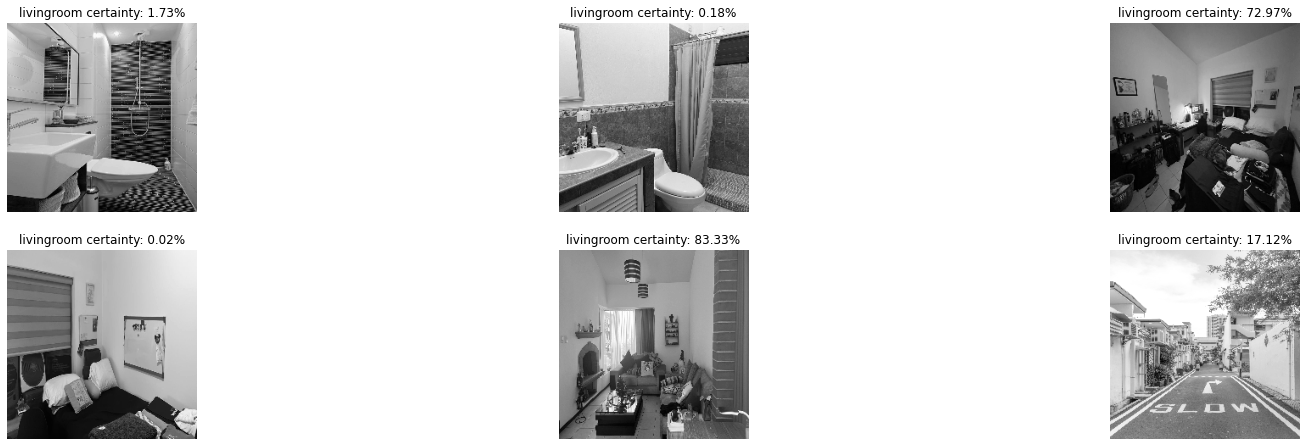

In [11]:
images_array = [
    '../test_real_images/bathroom_google.jpg',
    '../test_real_images/bathroom.png',
    '../test_real_images/bedroom_real.jpeg',
    '../test_real_images/bedroom_real_1.jpeg',
    '../test_real_images/living.png',
    '../test_real_images/street.jpg',
    # '../test_real_images/dining.png',
    # '../test_real_images/kitchen_1.png',
    # '../test_real_images/landscape.jpg',
    # '../test_real_images/office.jpg',
    # '../test_real_images/car.jpg',
    # '../test_real_images/mall.png',
]

IMAGE_CHANNEL = 1

def prepare(filepath):
    IMG_SIZE = 224
    img_array = cv.imread(filepath, cv.IMREAD_GRAYSCALE)
    new_array = cv.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, IMAGE_CHANNEL)

images_array= [prepare(img) for img in images_array]
plt.figure(figsize=(28, 16))
for i in range(len(images_array)):
  predicted = cnn.predict(images_array[i])
  ax = plt.subplot(4, 3, i+1)
  plt.imshow(images_array[i].reshape((224,224)).astype('uint8'), cmap='gray')
  plt.title(f"{ACTIVE_MODEL} certainty: {predicted[0][0]*100:.2f}%")
  plt.axis('off')

plt.show()

In [7]:
import h5py
import json
filename = f'{ACTIVE_MODEL}.h5'
model_h5 = h5py.File(filename, 'r')

model_config = model_h5["/"].attrs["model_config"]
config_dict = json.loads(model_config)

In [8]:
# print(config_dict["config"]["layers"][i]['class_name']) for i in 
for i in config_dict['config']['layers']:
    if i['class_name'] == 'Dropout':
        print(i)

{'class_name': 'Dropout', 'config': {'name': 'dropout', 'trainable': True, 'dtype': 'float32', 'rate': 0.5, 'noise_shape': None, 'seed': None}}


In [9]:
IMG_WIDTH=224
IMG_HEIGHT=224

def createDS(image_folder):
    batch_size = 32
    DEFAULT_SEED = 1234
    VALIDATION_SPLIT = 0.2
    train_ds = keras.utils.image_dataset_from_directory(
        image_folder,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        shuffle=True,
        labels='inferred',
        batch_size=batch_size,
        color_mode='grayscale',
        validation_split=VALIDATION_SPLIT,
        seed=DEFAULT_SEED,
        interpolation='gaussian',
        subset="training",
    )

    val_ds = keras.utils.image_dataset_from_directory(
        image_folder,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        shuffle=True,
        labels='inferred',
        batch_size=batch_size,
        color_mode='grayscale',
        validation_split=VALIDATION_SPLIT,
        seed=DEFAULT_SEED,
        interpolation='gaussian',
        subset="validation",
    )
    return train_ds, val_ds

train_ds, val_ds = createDS('../../../../../House_Room_Binary/living/')

Found 2678 files belonging to 2 classes.
Using 2143 files for training.
Found 2678 files belonging to 2 classes.
Using 535 files for validation.


1/1 [==============================] - 0s 204ms/step
tf.Tensor(
[[259  21]
 [ 16 239]], shape=(2, 2), dtype=int32)


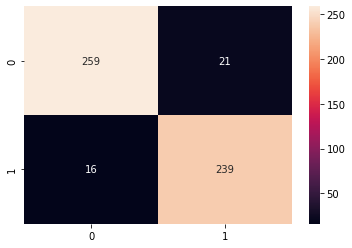

In [10]:

import seaborn as sns

predicted_output = []
real = []

for images, labels in val_ds.take(19):
  predicted = cnn.predict(images)
  for index, label in enumerate(labels):
    real.append(label)
    predicted_output.append(1.0 if predicted[index][0] >= 0.5 else 0.0)
    # print(label)

matrix = tf.math.confusion_matrix(
    real,
    predicted_output,
    2
)
sns.heatmap(matrix, annot=True, fmt="d")

print(matrix)